In [48]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import seaborn as sn
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_decision_regions

import pandas as pd
import numpy as np
import os
import glob

### *functions*

In [ ]:
def get_label_from_filename(filename): 
    if "Phantom" in filename: return "Phantom"
    elif "Ruko_F11_Pro" in filename: return "Ruko_F11_Pro"
    elif "Mavic_Air_2_" in filename: return "Mavic_Air_2"
    elif "Mavic_Air_2S" in filename: return "Mavic_Air_2S"
    elif "DeerC" in filename: return "DeerC"
    elif "Mini_SE" in filename: return "Mini_SE"
    elif "test" in filename: return "test"
    elif "None" in filename: return "None"
    else: return "unknown_label"



def load_iq(f, chunk_size, every_n_rows):
    # The chunking in this algo is so that we can read in large files (156M lines or more). 
    # In order to reduce compution time, we skip n number of rows. 
    result = pd.DataFrame()
    for chunk in pd.read_csv(f, chunksize=chunk_size):
        result = pd.concat([result, chunk.iloc[::every_n_rows, :]], ignore_index=True)

    result = result[['i', 'q']].to_numpy()
    return result

    

### *variables*

In [ ]:
# Path to your IQ files
data_dir = "./data/"
drone_csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
print(drone_csv_files)

chunk_size = 10_000 # how much to hold in memory at a time
every_n_rows = 16

# Example: sample windows with 50% overlap
window_size = 4096 # number of iq samples per chunk (=2 would be 1 sample, i,q)
samples_per_file = 1000
step = 2048

['./data/1970-01-01-00-05-14_None-5GHz_5800MHz_chan_0.csv', './data/2025-07-23-21-18-31_Ruko_F11_Pro_Video_5805MHz_chan_0.csv', './data/2025-07-18-22-21-33_test_5735MHz_chan_0.csv', './data/2025-07-23-21-27-37_DeerC_DE2_2455MHz_chan_0.csv', './data/2025-07-23-21-18-45_Ruko_F11_Pro_Video_5805MHz_chan_0.csv', './data/1970-01-01-00-04-35_None-2.4GHz_2400MHz_chan_0.csv', './data/2025-07-23-21-13-39_Ruko_F11_Pro_2460MHz_chan_0.csv', './data/2025-07-18-22-57-17_Mavic_Air_2_5735MHz_chan_0.csv', './data/2025-07-22-19-21-26_Mini_SE_5805MHz_chan_0.csv', './data/2025-07-23-21-13-29_Ruko_F11_Pro_2460MHz_chan_0.csv', './data/2025-07-22-19-21-38_Mini_SE_5805MHz_chan_0.csv', './data/2025-07-18-23-03-13_Mavic_Air_2S_5735MHz_chan_0.csv', './data/2025-07-23-21-28-22_DeerC_DE2_2450MHz_chan_0.csv', './data/1970-01-01-00-04-18_None-2.4GHz_2400MHz_chan_0.csv', './data/1970-01-01-00-05-01_None-5GHz_5800MHz_chan_0.csv', './data/2025-07-23-21-28-13_DeerC_DE2_2450MHz_chan_0.csv', './data/2025-07-23-21-13-50_Ruk

In [51]:
X = []
y = []

segments = []
labels = []


# create an array of dataframes.
# each dataframe containing iq samples from one file
for file in drone_csv_files:
    print("File: ", file)
    label = get_label_from_filename(file)
    # print("Label: ", label)
    iq = load_iq(file, chunk_size, every_n_rows)  # shape (N, 2)
    print("File:\n", iq)
    for i in range(0, len(iq)-window_size, step):
        window = iq[i:i+window_size].flatten()
        segments.append(window)
        labels.append(label)
    # print("Segments:\n", segments)
    # print("Labels:\n", labels)


X = [segment.flatten() for segment in segments]
y = labels

X = np.array(X)
y = np.array(y)
print(X)
print(y)

File:  ./data/1970-01-01-00-05-14_None-5GHz_5800MHz_chan_0.csv
File:
 [[-7123.  4273.]
 [-7123. -9972.]
 [-2849.  1424.]
 ...
 [ 2849.  7123.]
 [    0. -4273.]
 [-1424. -2849.]]
File:  ./data/2025-07-23-21-18-31_Ruko_F11_Pro_Video_5805MHz_chan_0.csv
File:
 [[  0. -61.]
 [-50.  40.]
 [ 20.  50.]
 ...
 [ 50.  10.]
 [ 50.  71.]
 [-71.   0.]]
File:  ./data/2025-07-18-22-21-33_test_5735MHz_chan_0.csv
File:
 [[ -30.  -61.]
 [ -92.    0.]
 [ -61.  -92.]
 ...
 [ -30.   92.]
 [ 123.  -30.]
 [   0. -123.]]
File:  ./data/2025-07-23-21-27-37_DeerC_DE2_2455MHz_chan_0.csv
File:
 [[-275.  120.]
 [ 189.    0.]
 [-137. -412.]
 ...
 [ 189.  154.]
 [  17.   68.]
 [ -17.  120.]]
File:  ./data/2025-07-23-21-18-45_Ruko_F11_Pro_Video_5805MHz_chan_0.csv
File:
 [[ 20.  -6.]
 [ 13. -13.]
 [  6.  26.]
 ...
 [-40. -33.]
 [-13. -13.]
 [-20. -33.]]
File:  ./data/1970-01-01-00-04-35_None-2.4GHz_2400MHz_chan_0.csv
File:
 [[-1129. -4519.]
 [ 2259. -2259.]
 [-9039.  3389.]
 ...
 [-5649.     0.]
 [-4519.  1129.]
 [-4519

In [52]:
# print("labels: ")
# print(np.unique(y))
# print()

for sample, label in zip(X, np.unique(y)): 
    print("X feature:\n", sample)
    print("IQ samples in X feature: ", int(sample.size / 2))
    print("y label: ", label)
    print('-------------------------------------------')

X feature:
 [-7123.  4273. -7123. ... -5698. -2849. -5698.]
IQ samples in X feature:  4096
y label:  DeerC
-------------------------------------------
X feature:
 [ -9972. -14246.  -1424. ...  -1424.   2849.  -8547.]
IQ samples in X feature:  4096
y label:  Mavic_Air_2
-------------------------------------------
X feature:
 [ -4273.   1424.  -1424. ...  -1424.  -8547. -11397.]
IQ samples in X feature:  4096
y label:  Mavic_Air_2S
-------------------------------------------
X feature:
 [-2849. -1424.     0. ... -2849.  2849.     0.]
IQ samples in X feature:  4096
y label:  Mini_SE
-------------------------------------------
X feature:
 [ 4273.  4273. -8547. ...     0.  2849.  5698.]
IQ samples in X feature:  4096
y label:  None
-------------------------------------------
X feature:
 [ 8547.     0.  7123. ...     0. -2849.  7123.]
IQ samples in X feature:  4096
y label:  Ruko_F11_Pro
-------------------------------------------
X feature:
 [  5698.  -4273.  -4273. ... -11397.  -8547.   14

### *Training, fitting & predicting*

In [53]:
# Train/test split (e.g. 80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Standardize features (zero mean, unit variance)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
SVCModel = SVC(kernel='rbf', C=10, gamma='scale', max_iter=16_000)  # tweak C/gamma as needed
SVCModel.fit(X_train, y_train)
y_pred = SVCModel.predict(X_test)


### *Prediction & metrics*

In [ ]:
cr = classification_report(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(cr)
print(f"Accuracy: {accuracy:.4f}")
print()
print(cm)

              precision    recall  f1-score   support

       DeerC       0.80      0.43      0.56       457
 Mavic_Air_2       0.00      0.00      0.00       152
Mavic_Air_2S       0.84      0.49      0.62       152
     Mini_SE       0.73      0.48      0.58       305
        None       0.89      1.00      0.94       609
Ruko_F11_Pro       0.59      0.92      0.72       761
        test       0.73      0.89      0.80       121

    accuracy                           0.72      2557
   macro avg       0.65      0.60      0.60      2557
weighted avg       0.70      0.72      0.68      2557

Accuracy: 0.7180

[[195   0   1  12  30 219   0]
 [  0   0   0   0   0 117  35]
 [ 25   0  75   0   0  52   0]
 [ 23   0  13 146  21  97   5]
 [  0   0   0   0 609   0   0]
 [  2   0   0  43  13 703   0]
 [  0   0   0   0  13   0 108]]


/home/uav-cyberlab-rfml/iq-classification-classical-models/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/uav-cyberlab-rfml/iq-classification-classical-models/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/uav-cyberlab-rfml/iq-classification-classical-models/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zer

[[195   0   1  12  30 219   0]
 [  0   0   0   0   0 117  35]
 [ 25   0  75   0   0  52   0]
 [ 23   0  13 146  21  97   5]
 [  0   0   0   0 609   0   0]
 [  2   0   0  43  13 703   0]
 [  0   0   0   0  13   0 108]]


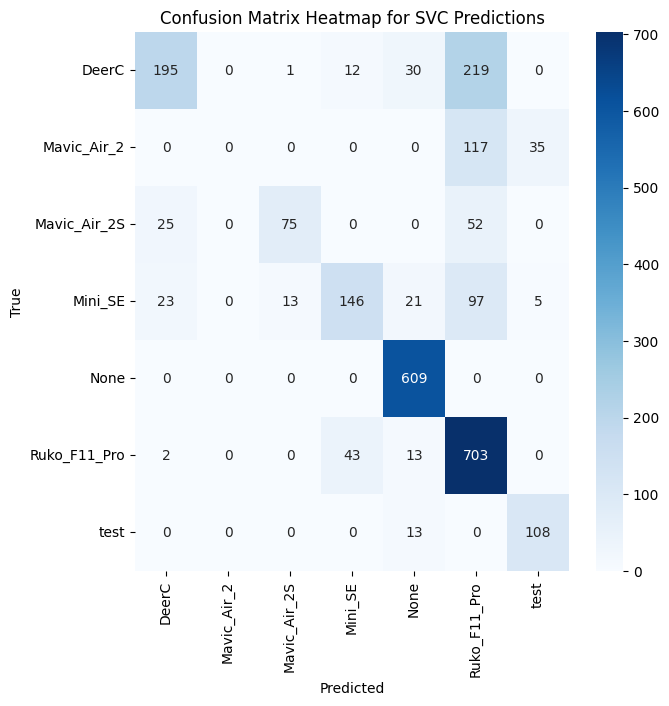

In [ ]:
# Create a heatmap of the confusion matrix

print(cm)

plt.figure(figsize=(7, 7))
sn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(labels), yticklabels=np.unique(labels))

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap for SVC Predictions')

# Show the plot
plt.show()


ValueError: y must be an integer array. Found <U12. Try passing the array as y.astype(np.int_)

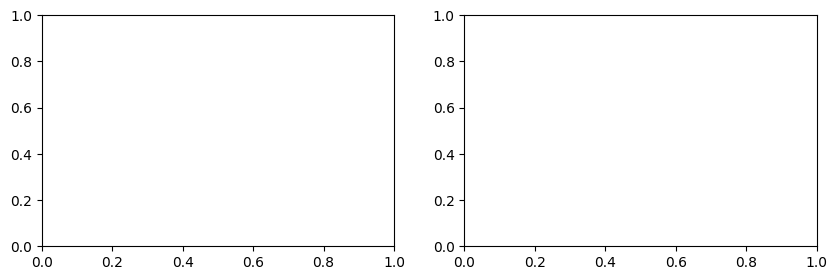

In [ ]:
# Display the decision boundary with training data
fig, ax = plt.subplots(1, 2, figsize = (10, 3))

fig = plot_decision_regions(X_train, y_train, SVCModel, ax = ax[0], zoom_factor=0.5)
ax[0].set_xlabel('In-Phase (I)', fontsize = 14)
ax[0].set_ylabel('Quadrature Phase (Q)', fontsize = 14)
ax[0].set_title('SVC (train)', fontsize = 14)
ax[0].set_xlim(-2.5, 10.5)
ax[0].set_ylim(-2.5, 2.5)

# Display the decision boundary with testing data
fig = plot_decision_regions(X_test, np.ravel(y_test), SVCModel, ax = ax[1], zoom_factor=0.25)
ax[1].set_xlabel('In-Phase (I)', fontsize = 14)
ax[1].set_title('SVC (test)', fontsize = 14)
ax[1].set_xlim(-2.5, 10.5)
ax[1].set_ylim(-2.5, 2.5)

plt.show()